<a href="https://colab.research.google.com/github/stevengiacalone/Python-workshop/blob/main/Session_5_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov-Chain Monte Carlo (MCMC) fitting

Last week, we used SciPy to do optimization and estimate the parameters of different models. This technique of curve fitting works when our models only have a few parameters, but often times we will need to work with models that have *dozens* of parameters. In these cases, traditional optimization methods fail and we need to turn to more complex numerical techniques. Markov-Chain Monte Carlos are a popular class of algorithms that are useful for these types of problems. In this session, we will design our own MCMC algorithm in Python. We will also use the popular Python package emcee to fit the light curve of a transiting exoplanet in order to calculate its size and orbit period.


An MCMC also has the advantage of being Bayesian in nature. This means that we can set limits on the values of the parameters we're fitting for using different distributions. According to Bayes' Theorem, the posterior probability of some model with parameters $\theta$ given some data $x$ has the relation

$$P(\theta | x) \propto P(\theta) P(x | \theta)$$

where $P(\theta)$ is the prior probability of the parameters $\theta$ having some value and $P(x | \theta)$ is the likelihood of of the data $x$ given some model with the parameters $\theta$. We can set the probability density function for the prior $P (\theta)$ to be whatever we want, which can give us much better constraints on the values of our parameters! We'll see an example of this below.

## Metropolis-Hastings Algorithm

There are many different MCMC algorithms, but one of the oldest (and arguably the simplest) is the Metropolis-Hastings algorithm. In this section, we'll code up this algorithm ourselves in Python. Here are the steps (from none other than [Wikipedia](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)):

1. Define some function that is proportional to the desired probability density function $P(\theta | x)$. In our case it will simply be $f (\theta | x) = P (\theta) P (x | \theta)$, just like in Bayes' Theorem.

2. Define our prior and likelihood functions. In this example, we will assume uniform priors where the prior probility is equal for all values in some range. For the likelihood function, we will use the Mean Squared Error function (the same one we used in the last session for curve fitting).

3. Define a proposal function $g(\theta^\prime | \theta_{t})$, which determines a new value of $\theta$ (which we will call $\theta^\prime$) given $\theta_t$. In our case, we will draw from a normal (Gaussian) distribution centered at $\theta_t$.

4. Select initial values for our parameters, $\theta_{t=0}$.

5. Propose a $\theta_{t+1}$ using the proposal function $g(\theta^\prime | \theta_{t})$.

6. Calculate the acceptance ratio $\alpha = f (\theta^\prime | x) /  f (\theta_{t} | x)$.

7. Either accept or reject $\theta^\prime$. Do do this, generate a random number $u$ between 0 and 1. If $u \leq \alpha$, accept $\theta^\prime$ and continue, with $\theta_{t+1} = \theta^\prime$. If $u > \alpha$, reject $\theta^\prime$ and try again with a new $\theta^\prime$.

8. Continue this process until you've reached the desired number of steps $T$.

Before we start, let's define a data set that we want to fit to. We'll work with a linear model here, for simplicity.

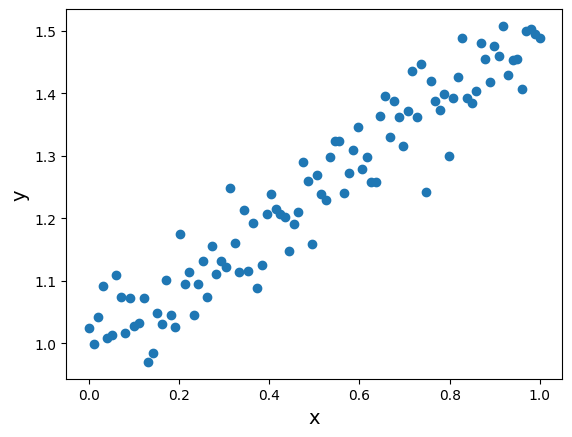

In [253]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

x = np.linspace(0, 1, 100)
m_true = 0.5
b_true = 1.0
y = m_true * x + b_true + np.random.normal(0, 0.05, 100)

plt.scatter(x, y)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

#### Step 1 - 2

We'll start by defining our function $f (\theta | x) = P (\theta) P (x | \theta)$. We'll work in log space, since that allow us to add things together instead of multiplying them.

In [256]:
# first, the prior function
def lnprior(theta):
    m, b = theta
    if (-5 < m < 5) & (-5 < b < 5):
        return 0
    else:
        return -np.inf

# next, the model we want to fit to and the corresponding likelihood function
def model(theta, x):
    m, b = theta
    return m * x + b

def lnlike(theta, x, y):
    m, b = theta
    lnL = -np.sum((model(theta, x) - y)**2)
    return lnL

# lastly, define the combined probability function
def lnprob(theta, x, y):
    lnp = lnprior(theta)
    lnL = lnlike(theta, x, y)
    return lnp + lnL

#### Step 3

Next, we'll define our proposal function that returns $\theta^\prime$ given $\theta_t$. Recall that we'll use a Gaussian distribution for the proposal function $g (\theta^\prime | \theta_t)$.

In [257]:
# use a Gaussian distribution with a standard deviation of 0.1 for m abd 0.05 for b
def g(theta):
    m, b = theta
    m2 = np.random.normal(m, 0.1)
    b2 = np.random.normal(b, 0.05)
    thetaprime = (m2, b2)
    return thetaprime

#### Step 4

Now we'll initialize some values for $m$ and $b$. In this example, we'll use 5 "walkers". Essentially, we will run the simulation for 5 different initial values and combine the results at the end.

In [258]:
# just draw random values for each
m_initial = np.random.uniform(low=-2, high=2, size=5)
b_initial = np.random.uniform(low=-2, high=2, size=5)

#### Step 5 - 8

Now we need to define our loops. We'll use a nested loop with 5 outer iterations (one for each walker) and 50000 inner iterations (i.e., 50000 steps per walker). For each walker step, we want to first calculate $\theta^\prime$ using the function we defined above. Then calculate $\alpha$ and determine if $\theta^\prime$ has been accepted or rejected. If it is accepted, go to the next iteration. If it is rejected, repeat the calculation for the same step.

I've gotten it set up for you below. Fill in the blank spots where indicated.

In [259]:
# make arrays to store values of m and b at each step
m_array = np.zeros([5,50000])
b_array = np.zeros([5,50000])

m_array[:,0] = m_initial
b_array[:,0] = b_initial

# outer loop (one iter per walker)
for i in range(5):

    # inner loop (one iter per step)
    for j in range(1,50000):

        theta = (m_array[i,j-1], b_array[i,j-1])

        ### draw new values of m and b ###
        thetaprime = g(theta)

        ### draw u and calculate alpha and determine which is greater ###
        u = np.random.uniform(low=0, high=1)
        alpha = np.exp(lnprob(thetaprime, x, y)) / np.exp(lnprob(theta, x, y))

        ### if u <= alpha, set the new values of m and b ###
        if u <= alpha:
            m_array[i,j] = thetaprime[0]
            b_array[i,j] = thetaprime[1]
        else:
            m_array[i,j] = theta[0]
            b_array[i,j] = theta[1]

Nice work! Let's visualize our results. The following histograms are the posterior distribution for our parameters, which us the best-fit values for $m$ and $b$ as well as their uncertainties. Let's remove the first 1000 steps from the arrays as "burn in."

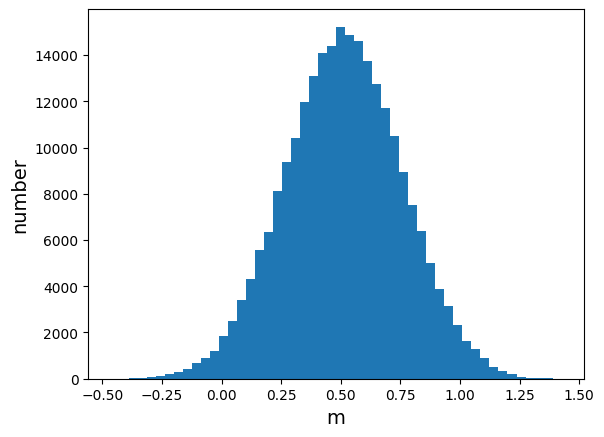

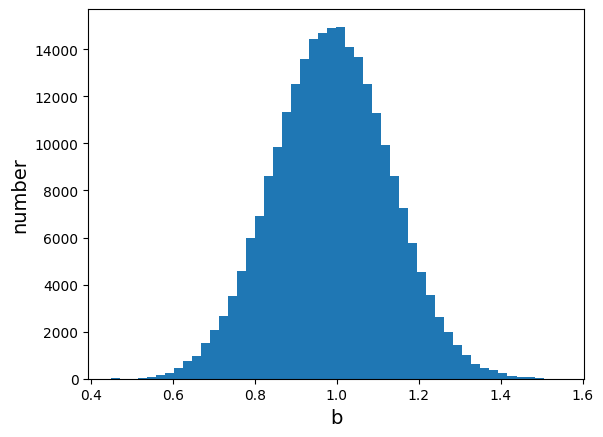

In [260]:
plt.hist(m_array[:,1000:].flatten(), bins=50)
plt.xlabel("m", fontsize=14)
plt.ylabel("number", fontsize=14)
plt.show()

plt.hist(b_array[:,1000:].flatten(), bins=50)
plt.xlabel("b", fontsize=14)
plt.ylabel("number", fontsize=14)
plt.show()

In [261]:
print("m =", np.mean(m_array[:,1000:].flatten()), "+/-", np.std(m_array[:,1000:].flatten()))
print("b =", np.mean(b_array[:,1000:].flatten()), "+/-", np.std(b_array[:,1000:].flatten()))

m = 0.5131544806539623 +/- 0.2448804012822793
b = 0.9874930535489912 +/- 0.14162685170383982


Here's another visualization of how these posteriors were generated:

![](https://upload.wikimedia.org/wikipedia/commons/d/de/Flowchart-of-Metropolis-Hastings-M-H-algorithm-for-the-parameter-estimation-using-the.png)



For a good interactive tool that can visualize this process, see [this page](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana).

We can also sample these arrays to see what kinds of lines our posteriors produce.

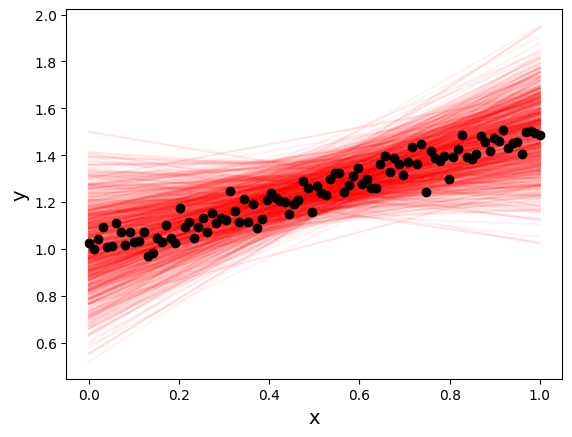

In [262]:
sample_idxs = np.random.randint(low=5000, high=9999, size=1000)

plt.scatter(x, y, c='k')
for i in range(1000):
    this_m = m_array[0, sample_idxs[i]]
    this_b = b_array[0, sample_idxs[i]]
    this_model = model((this_m, this_b), x)
    plt.plot(x, this_model, 'r-', alpha=0.05, zorder=0)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

Let's repeat this exercise one more time, but using different priors on $m$ and $b$. Let's assume that we have some initial constraints on the values that let us set Gaussian priors instead of uniform priors. Run the cell below to see how this affects our constraints on $m$ and $b$ from the MCMC.

In [263]:
# write new prior function that uses Gaussian priors
def lnprior(theta):
    # assume we know b is 0.5 +/- 0.2 a priori
    m, b = theta
    mu_m = 0.5
    sigma_m = 0.2
    m_logprior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_m))-0.5*(m-mu_m)**2/sigma_m**2
    # assume we know b is 1 +/- 0.1 a priori
    mu_b = 1
    sigma_b = 0.1
    b_logprior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_b))-0.5*(b-mu_b)**2/sigma_b**2
    return m_logprior + b_logprior

# next three functions are unchanged
def model(theta, x):
    m, b = theta
    return m * x + b

def lnlike(theta, x, y):
    m, b = theta
    lnL = -np.sum((model(theta, x) - y)**2)
    return lnL

def lnprob(theta, x, y):
    lnp = lnprior(theta)
    lnL = lnlike(theta, x, y)
    return lnp + lnL

# make arrays to store values of m and b at each step
m_array2 = np.zeros([5,50000])
b_array2 = np.zeros([5,50000])

m_array2[:,0] = m_initial
b_array2[:,0] = b_initial

# outer loop (one iter per walker)
for i in range(5):

    # inner loop (one iter per step)
    for j in range(1,50000):

        theta = (m_array2[i,j-1], b_array2[i,j-1])

        ### draw new values of m and b ###
        thetaprime = g(theta)

        ### draw u and calculate alpha and determine which is greater ###
        u = np.random.random()
        alpha = np.exp(lnprob(thetaprime, x, y)) / np.exp(lnprob(theta, x, y))

        ### if u <= alpha, set the new values of m and b and break the while loop by setting accept = True
        if u <= alpha:
            m_array2[i,j] = thetaprime[0]
            b_array2[i,j] = thetaprime[1]
        else:
            m_array2[i,j] = theta[0]
            b_array2[i,j] = theta[1]

# print results
print("m =", np.mean(m_array2[:,1000:].flatten()), "+/-", np.std(m_array2[:,1000:].flatten()))
print("b =", np.mean(b_array2[:,1000:].flatten()), "+/-", np.std(b_array2[:,1000:].flatten()))

m = 0.4996524025238363 +/- 0.13045912359634557
b = 0.9962553779797332 +/- 0.07196875416916307


We can see that our constraints on $m$ and $b$ are now much tigher!

Let's compare the posterior distributions for $m$ and $b$ in the two runs.

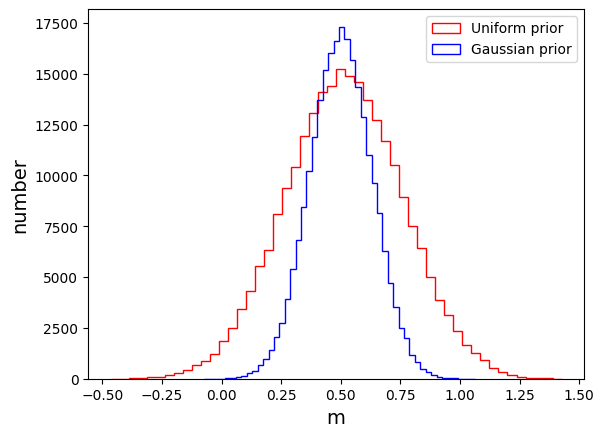

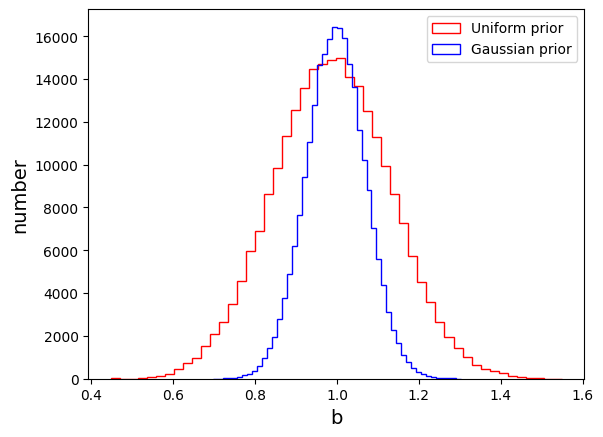

In [264]:
plt.hist(m_array[:,1000:].flatten(), bins=50, histtype="step", color="r", label="Uniform prior")
plt.hist(m_array2[:,1000:].flatten(), bins=50, histtype="step", color="b", label="Gaussian prior")
plt.xlabel("m", fontsize=14)
plt.ylabel("number", fontsize=14)
plt.legend()
plt.show()

plt.hist(b_array[:,1000:].flatten(), bins=50, histtype="step", color="r", label="Uniform prior")
plt.hist(b_array2[:,1000:].flatten(), bins=50, histtype="step", color="b", label="Gaussian prior")
plt.xlabel("b", fontsize=14)
plt.ylabel("number", fontsize=14)
plt.legend()
plt.show()

## Exercise

In this exercise, we'll use the Python package emcee to perform an MCMC fit of data from the Kepler space telescope, which searched for transiting planets around Sun-like stars. The system we will look at, Kepler-41, has a hot Jupiter, a Jupiter-size planet orbiting very close to its host star. We will use an MCMC to calculate the size and orbital period of the planet precisely.

First, let's install the Python packages we'll use.

In [265]:
pip install emcee

In [266]:
pip install corner

In [267]:
pip install batman-package

#### Data exploration

Let's take a look at the data. We'll import the file "Kepler-41.csv" from the GitHub and plot it. The file has three columns: time, flux, and flux_err (i.e., the uncertainty of each flux point).

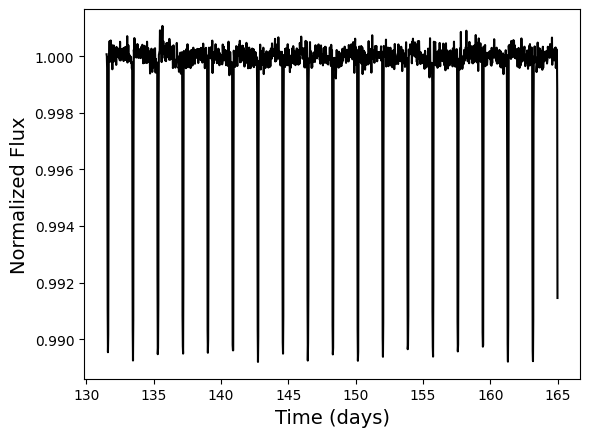

In [268]:
import pandas as pd

df = pd.read_csv("Kepler-41.csv")
x = df.time.values
y = df.flux.values
yerr = df.flux_err.values

plt.plot(x, y, 'k-')
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.show()

The big (~1%) dips in brightness are due to the hot Jupiter passing in front of the star! We can see visually that the planet has an orbital period of about 1.855 days and that the first transit in the data occurs at about 131.6 days. Let's phase-fold the data to that period to see what the transit looks like up close.

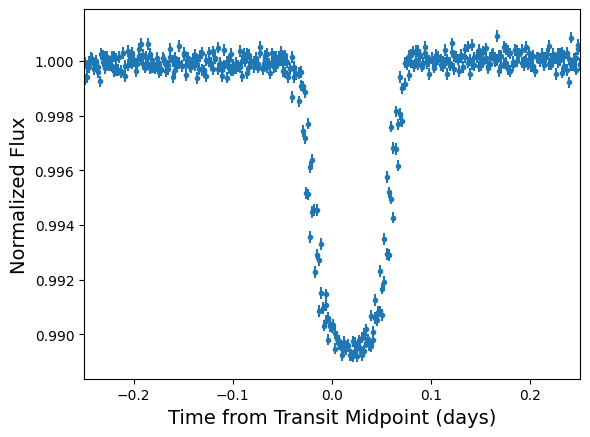

In [269]:
P_guess = 1.855
t0_guess = 131.6
x_fold = (x - t0_guess + P_guess/2) % P_guess - P_guess/2

plt.errorbar(x_fold, y, yerr, fmt='.')
plt.xlabel("Time from Transit Midpoint (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.xlim([-0.25,0.25])
plt.show()

We can see that our initial guesses aren't perfect. We'll get better estimates using the MCMC.

#### Modeling transits with BATMAN

BATMAN is a Python packages used to model exoplanet transits. You don't need to know much about this, other than the fact that it is the model we'll be fitting the data to. Our model will have six parameters:

- $P_{\rm orb}$: The orbital period of the planet (in days)
- $T_0$: The time of the midpoint of the first transit (in days)
- $R_p$: The size of the planet (in Earth radii)
- $i$: The inclination of the planet orbit (in degrees)
- $u_1$: A parameter describing the limb darkening of the star
- $u_2$: Another parameter describing the limb darkening of the star

We'll hold the following quantities fixed (see the discovery paper [Santerne et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...536A..70S/abstract)):

- $R_\star$: The radius of the host star, which we will set to $1.02 \, R_\odot$
- $M_\star$: The mass of the host star, which we will set to $1.12 \, M_\odot$
- $e$: The orbital eccentricity of the planet, which we will set to 0

The function below returns the flux of the star given the six parameters above and a time array (in days).

In [270]:
import batman

G = 6.67e-8 # Uniersal Grav Constant in cgs units
Rearth = 6.371e+8 # Earth radius in cm
Rsun = 6.957e+10 # Sun radius in cm
Msun = 1.989e+33 # Sun mass in g
Rstar = 1.02 * Rsun
Mstar = 1.12 * Msun

params = batman.TransitParams()

def model(theta, x):
    Porb, T0, Rp, i, u1, u2 = theta

    params.t0 = T0                                                      #time of inferior conjunction
    params.per = Porb                                                   #orbital period
    params.rp = Rp*Rearth/Rstar                                         #planet radius (in units of stellar radii)
    params.a = ((G*Mstar)/(4*np.pi**2)*(Porb*86400)**2)**(1/3) / Rstar  #semi-major axis (in units of stellar radii)
    params.inc = i                                                      #orbital inclination (in degrees)
    params.ecc = 0.                                                     #eccentricity
    params.w = 90.                                                      #longitude of periastron (in degrees)
    params.u = [u1, u2]                                                 #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"                                      #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux = m.light_curve(params)          #calculates light curve

    return flux

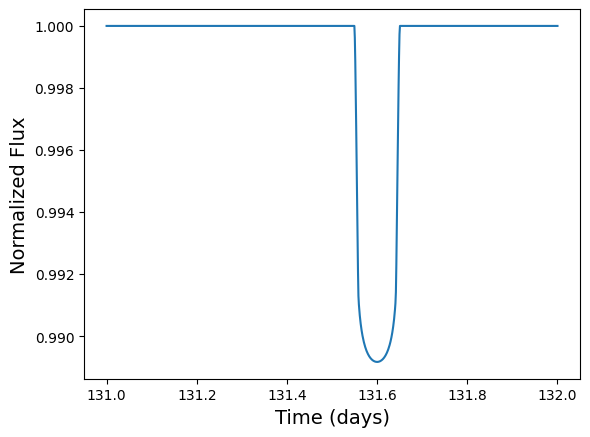

In [277]:
test_time = np.linspace(131, 132, 1000)
Rp_guess = 11
i_guess = 90
u1_guess = 0.2
u2_guess = 0.2
test_flux = model((P_guess, t0_guess, Rp_guess, i_guess, u1_guess, u2_guess), test_time)


plt.plot(test_time, test_flux)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.show()

#### Running MCMC using emcee

emcee is a Python package that implements the MCMC we wrote above, along with some extra features. Functionally, it is pretty similar to what we did. First, we need to define our log prior, log likelihood, and log probability functions. Let's do the folling for each below:

- lnprior -- Use the following priors
    - $P_{\rm orb}$: A Gaussian prior centered on 1.855 days and with a standard deviation of 0.01 days.
    - $T_0$: A uniform prior between 131.5 days and 131.7 days (inclusive).
    - $R_{\rm p}$: A uniform prior between 1 Earth radius and 20 Earth radii (inclusive).
    - $i$: A uniform prior between 70 degrees and 90 degrees (inclusive).
    - $u_1$ and $u_2$: Uniform priors between -1 and 1 (inclusive).

- lnlike -- Use the following likelihood function:

$$ \log{L} = -0.5 ∑ (({\rm model} - y)^2 / y{\rm err}^2) $$

- lnprob -- Use the same function that we used earlier. That is, express the log of the posterior probability as the sum of the log prior and log likelihood.

In [278]:
def lnprior(theta):
    P, t0, Rp, i, u1, u2 = theta

    mu_P = 1.855
    sigma_P = 0.01
    P_logprior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_P))-0.5*(P-mu_P)**2/sigma_P**2

    if (131.5 <= t0 <= 131.7) & (1 <= Rp <= 20) & (70 <= i <= 90) & (-1 <= u1 <= 1) & (-1 <= u2 <= 1):
        return P_logprior
    else:
        return -np.inf

def lnlike(theta, x, y, yerr):
    this_model = model(theta, x)
    lnL = -0.5 * np.sum((this_model - y)**2 / yerr**2)
    return lnL

def lnprob(theta, x, y, yerr):
    lnp = lnprior(theta)
    lnL = lnlike(theta, x, y, yerr)
    return lnp + lnL

Once you've gotten those functions down, run the next cell. This will run the MCMC, which contains 12 walkers and 50000 steps.

In [279]:
import emcee

nwalkers = 12 # need to have at least twice as many walkers as free parameters
ndim = 6 # this is the number of free parameters we're fitting for

# set the initial guesses for each of the 12 walkers
initial_guess = np.array([P_guess, t0_guess, Rp_guess, i_guess, u1_guess, u2_guess])
pos = initial_guess + 1e-7 * np.random.randn(nwalkers, ndim)

# initiate the MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 50000, progress=True);

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [02:37<00:00, 317.94it/s]


Let's take a look at our best-fit parameters. Are these consistent with those from the literature reported [here](https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-41%20b#planet_Kepler-41-b_collapsible)?

In [280]:
flat_samples = sampler.get_chain(discard=10000, thin=15, flat=True)

print("Porb =", np.mean(flat_samples[:,0]), "+/-", np.std(flat_samples[:,0]))
print("T0 =", np.mean(flat_samples[:,1]), "+/-", np.std(flat_samples[:,1]))
print("Rp =", np.mean(flat_samples[:,2]), "+/-", np.std(flat_samples[:,2]))
print("i =", np.mean(flat_samples[:,3]), "+/-", np.std(flat_samples[:,3]))
print("u1 =", np.mean(flat_samples[:,4]), "+/-", np.std(flat_samples[:,4]))
print("u2 =", np.mean(flat_samples[:,5]), "+/-", np.std(flat_samples[:,5]))

Porb = 1.8555971602291739 +/- 1.5898315276304588e-05
T0 = 131.614075679907 +/- 0.00017413833386138586
Rp = 9.620806260230637 +/- 0.01830726764395161
i = 89.85395327851812 +/- 0.10998434370364708
u1 = 0.9704086782745266 +/- 0.02156310686028435
u2 = -0.07928781114393497 +/- 0.03697957798489199


We can visualize our resulting posterior distributions using a "corner" plot. Corner plots are useful because they allow us to easily identify covariances between the parameters.

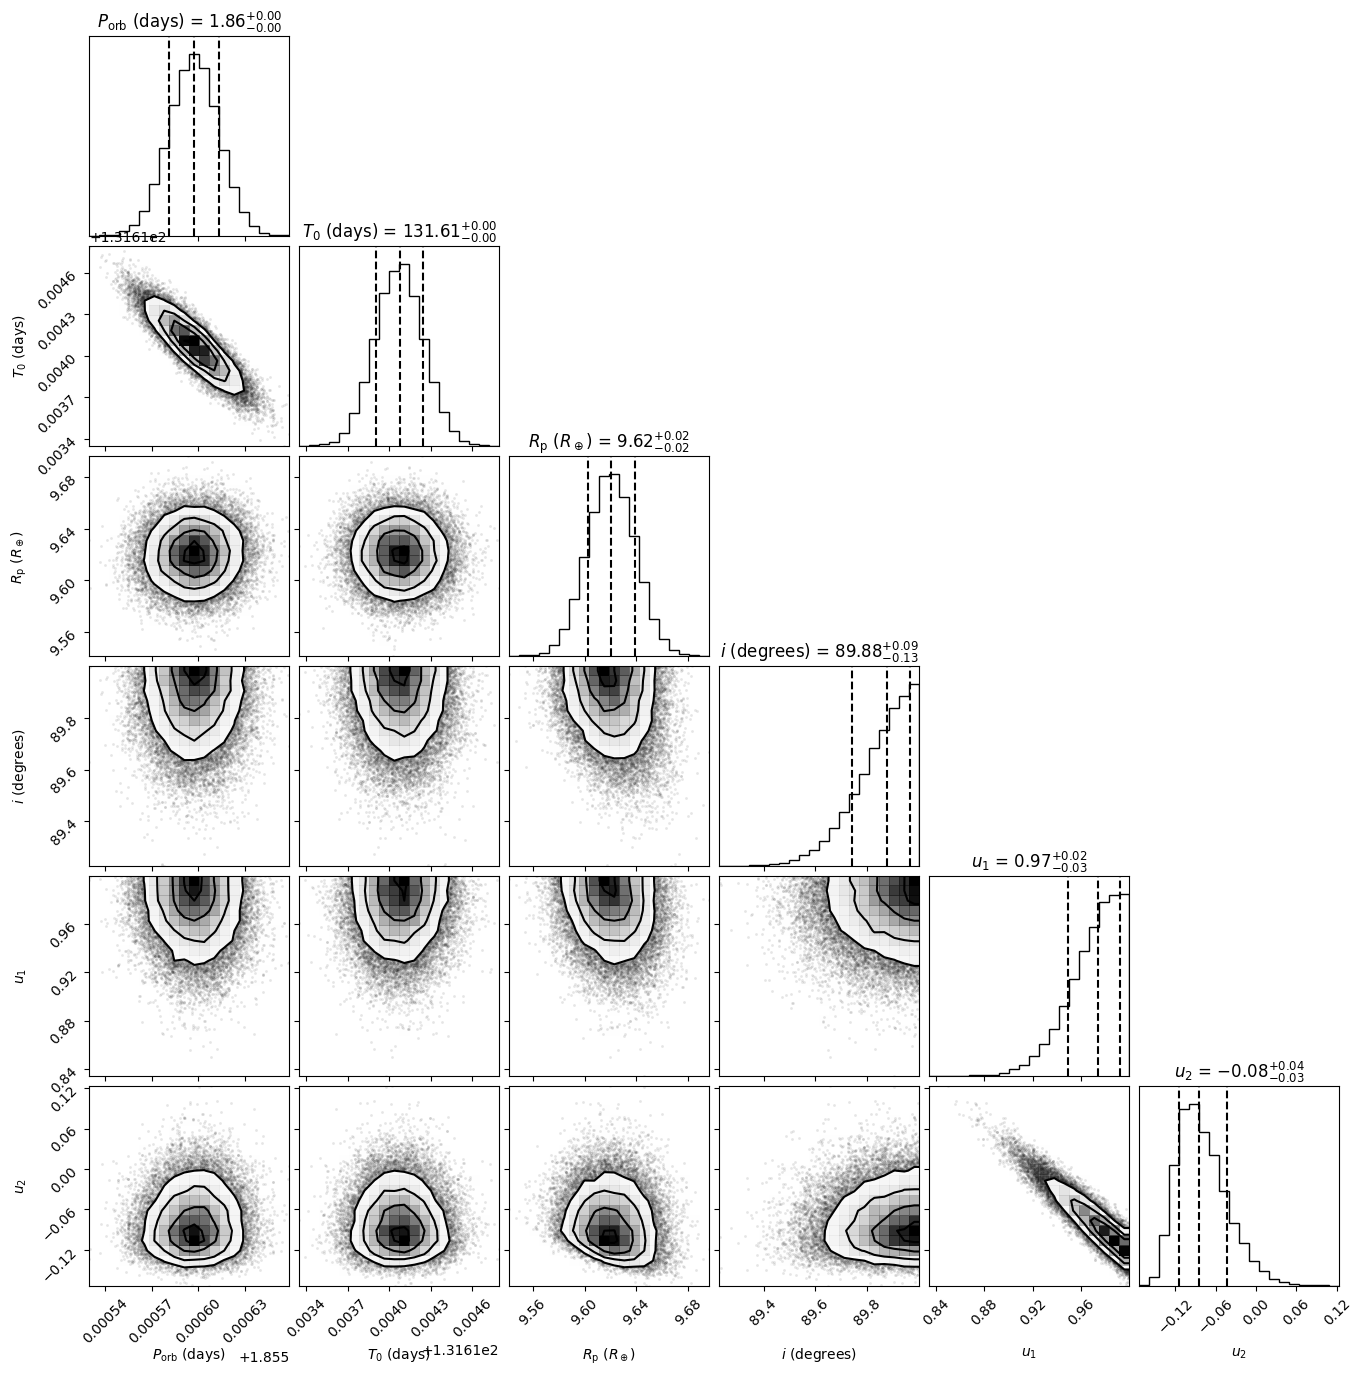

In [281]:
import corner

labels=["$P_\\mathrm{orb}$ (days)", "$T_0$ (days)", "$R_\\mathrm{p}$ ($R_\\oplus$)", "$i$ (degrees)", "$u_1$", "$u_2$"]

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12},
);

Lastly, let's plot samples from the posterior and compare them to the Kepler data.

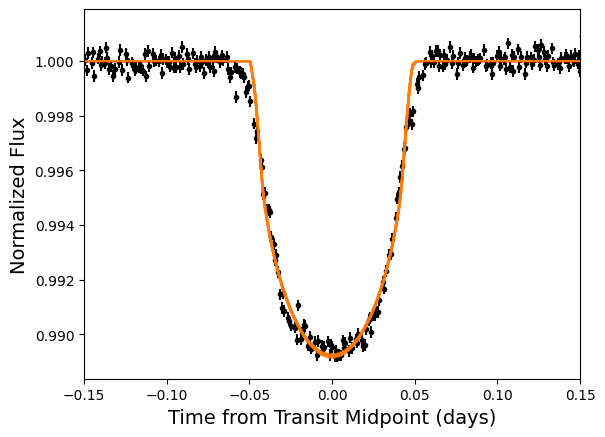

In [282]:
P_fit = np.median(flat_samples[:,0])
t0_fit = np.median(flat_samples[:,1])
x_fold = (x - t0_fit + P_fit/2) % P_fit - P_fit/2

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    idx_sorted = np.argsort(x_fold)
    plt.plot(x_fold[idx_sorted], model(sample, x)[idx_sorted], "C1", alpha=0.1)

plt.errorbar(x_fold, y, yerr, fmt='.', color='k', zorder=0)
plt.xlabel("Time from Transit Midpoint (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.xlim([-0.15,0.15])
plt.show()

There are some inconsistencies, but overall it looks pretty good!

That concludes our sesson on MCMC fitting. If you want to mess around with emcee some more, check out the documentation [here](https://emcee.readthedocs.io/en/stable/). There are also other MCMC packages in python, such as [pymc](https://www.pymc.io/welcome.html) and [pystan](https://pystan.readthedocs.io/en/latest/). You may come across these in your research, so it's good to have them on your radar!